In [1]:
import pandas as pd
import numpy
import os

import nltk

import torch
!pip install transformers
import transformers

     |████████████████████████████████| 2.1MB 17.1MB/s 
     |████████████████████████████████| 901kB 50.9MB/s 
     |████████████████████████████████| 3.3MB 48.9MB/s 


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
from google.colab import files
uploaded = files.upload()

Saving FA18_messages_with_gender_recipients_hand_lableled.xlsx to FA18_messages_with_gender_recipients_hand_lableled.xlsx


In [4]:
# Read in excel file with recipient gender hand labeled 
df_fall_18_messages = pd.read_excel('FA18_messages_with_gender_recipients_hand_lableled.xlsx', index_col=0)
print(df_fall_18_messages.shape)
df_fall_18_messages.head()

(5039, 5)


,User ID,Sender Race,Sender Gender,Recipient Gender,Text
0,42683026,WHITE,F,F,Hey @Katie Poteet I know you said we should em...
1,25501571,WHITE,F,F,@Mary Cassell I would email Dr. K anyway with ...
2,42683026,WHITE,F,F,"Ok, thanks a lot. I have the email typed but w..."
3,25501571,WHITE,F,F,Upstairs from our lecture hall
4,25501571,WHITE,F,F,Sherman 207!!!


In [5]:
# Encode recipient gender char as int and create as new column in dataframe
# Remove rows where recipient's gender is unknown
male_val = 0
female_val = 1
neutral_val = 2

def encode(c):
    if (c == 'M'):
        return male_val
    elif (c == 'F'):
        return female_val
    elif (c == 'N'):
        return neutral_val

# Add column in dataframe for encoded gender
df_fall_18_messages['Recipient Gender Encoded'] = [encode(x) for x in df_fall_18_messages['Recipient Gender']]
# Drop nas (some genders were unknown in the dataset)
df_fall_18_messages = df_fall_18_messages[df_fall_18_messages['Recipient Gender Encoded'].notna()]

data = [df_fall_18_messages['Text'], df_fall_18_messages['Recipient Gender Encoded']]

headers = ['Text', 'Recipient Gender Encoded']

df_fall_18_messages = pd.concat(data, axis=1, keys=headers)

print(df_fall_18_messages.shape)
df_fall_18_messages.head()

(4872, 2)


,Text,Recipient Gender Encoded
0,Hey @Katie Poteet I know you said we should em...,1.0
1,@Mary Cassell I would email Dr. K anyway with ...,1.0
2,"Ok, thanks a lot. I have the email typed but w...",1.0
3,Upstairs from our lecture hall,1.0
4,Sherman 207!!!,1.0


In [6]:
nltk.download('punkt')
df_fall_18_sentences = pd.DataFrame(columns=['Sentence', 'Recipient Gender'])
counter = 0
for index, row in df_fall_18_messages.iterrows():
    for sentence in nltk.tokenize.sent_tokenize(row['Text']):
        values_to_add = {'Sentence': sentence, 'Recipient Gender': row['Recipient Gender Encoded']}
        row_to_add = pd.Series(values_to_add, name = counter)
        df_fall_18_sentences = df_fall_18_sentences.append(row_to_add)
        counter += 1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
print(numpy.argwhere(numpy.isnan(numpy.array(df_fall_18_sentences['Recipient Gender']))))
print(df_fall_18_sentences.shape)
df_fall_18_sentences.head()

[]
(6354, 2)


,Sentence,Recipient Gender
0,Hey @Katie Poteet I know you said we should em...,1.0
1,I’m planning to do the Baltimore Community Too...,1.0
2,@Mary Cassell I would email Dr. K anyway with ...,1.0
3,"If not, it’s still good for her to know what y...",1.0
4,"Ok, thanks a lot.",1.0


In [8]:
print(df_fall_18_sentences['Recipient Gender'].value_counts())

2.0    2918
1.0    1794
0.0    1642
Name: Recipient Gender, dtype: int64


In [9]:
# Get the lists of sentences and their labels.
sentences = df_fall_18_sentences['Sentence'].values
labels = df_fall_18_sentences['Recipient Gender'].values

In [10]:
# Initialize the tokenizer with a pretrained model
tokenizer = transformers.BertTokenizer.from_pretrained('distilbert-base-uncased')

In [11]:
# Convert the string "granola bars" to tokenized vocabulary IDs
sentence_ids = df_fall_18_sentences['Sentence'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [12]:
max_len = 0
for id_vector in sentence_ids.values:
    if len(id_vector) > max_len:
        max_len = len(id_vector)

padded_ids = numpy.array([i + [0]*(max_len-len(i)) for i in sentence_ids.values])
print("max id array length: ", max_len)

max id array length:  105


In [13]:
attention_mask = numpy.where(padded_ids != 0, 1, 0)
print(attention_mask.shape)

(6354, 105)


In [14]:
# Convert lists to tensors
ids_tensor = torch.LongTensor(padded_ids)
attention_masks_tensor = torch.tensor(attention_mask)

In [19]:
ids_batches = torch.tensor_split(ids_tensor, 10)
attention_masks_batches = torch.tensor_split(attention_masks_tensor, 10)

In [20]:
model = transformers.BertModel.from_pretrained('distilbert-base-uncased', output_hidden_states=True)
# Set the device to GPU (cuda) if available, otherwise stick with CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval()

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bi

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [21]:
hidden_states = []
for i in range(0,len(ids_batches)):
  with torch.no_grad():
    ids_batch = ids_batches[i].to(device)
    attention_masks_batch = attention_masks_batches[i].to(device)
    hidden_state = model(ids_batch, attention_mask=attention_masks_batch)
    states = torch.mean(hidden_state[2][-2], dim=1).squeeze().cpu()
    for sentence in states: 
      hidden_states.append(sentence)
    ids_batch.cpu()
    attention_masks_batch.cpu()
    del hidden_state, ids_batch, attention_masks_batch
    torch.cuda.empty_cache()

In [22]:
print("len(hidden_states): ",len(hidden_states))
print("hidden_states[0].shape: ",hidden_states[0].shape)

len(hidden_states):  6354
hidden_states[0].shape:  torch.Size([768])


In [23]:
numpy_array = []
for tensor in hidden_states:
  numpy_array.append(tensor.numpy())

X = numpy.array(numpy_array)
y = df_fall_18_sentences["Recipient Gender"]

In [24]:
df_features = pd.DataFrame(X)
df_features.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
5729,-0.134583,0.062177,1.458376,0.750637,0.079481,0.083587,-0.131703,-0.062617,-0.675590,-0.700285,0.759642,0.077144,0.429482,-1.202718,-0.415402,-0.788152,-0.066272,-0.248782,-1.319824,0.534457,-0.675336,0.128751,0.187158,0.720863,-0.048104,0.047838,-1.272750,-0.804106,-0.172438,1.444689,1.127269,-0.708241,0.347100,-1.396768,0.820770,-0.588736,-0.159436,-0.898084,-1.128461,-0.560359,...,-2.056887,0.731983,0.308551,0.250022,1.920964,1.514480,-2.400119,0.935686,1.378945,-0.489329,-0.781684,-1.538385,-1.553320,0.179927,-1.385678,0.772697,-0.032749,-1.281745,0.304477,1.194919,-0.517236,0.206366,0.988831,1.265005,0.825333,-0.064232,0.630105,0.116500,-0.679610,-0.032482,1.047647,-1.224808,0.944177,0.093853,-0.303051,-1.014945,-1.267905,1.415123,1.648605,1.899328
3847,-0.185526,0.409991,1.526158,0.657484,-0.031235,-0.029933,-0.057835,0.012412,-0.599176,-0.639283,0.493148,0.315974,0.341944,-0.921033,-0.364396,-0.993129,-0.104834,-0.051794,-1.069836,0.454011,-0.814265,0.120317,0.151213,0.755257,0.185715,0.145819,-1.200614,-0.788486,-0.168714,1.544699,1.134223,-0.529618,0.313488,-1.504750,0.771340,-0.593427,0.015597,-0.837215,-1.374135,-0.865145,...,-1.876905,0.829332,0.475114,0.164766,1.664827,1.374231,-2.297637,0.906154,1.395484,-0.829772,-0.653427,-1.075279,-1.576261,0.260424,-1.148408,1.252943,-0.094948,-1.281621,0.526156,1.015856,-0.297670,0.502216,1.072469,1.306626,0.703565,-0.384895,1.110503,-0.047168,-0.673106,-0.209510,0.868151,-1.303756,0.665489,-0.056077,-0.290068,-0.940124,-1.095336,1.282915,1.504017,1.951632
107,-0.220425,0.316685,1.346640,0.408896,0.265319,-0.301244,-0.095979,-0.108933,-0.409497,-1.021305,0.759734,0.479804,0.258653,-1.027137,-0.261022,-0.782398,-0.312557,-0.159328,-1.335720,0.467916,-0.374495,-0.201495,0.112832,0.434643,0.488832,0.069889,-1.395032,-0.870054,-0.429886,1.477581,1.002971,-0.693079,0.170930,-1.572942,0.685763,-0.521990,0.024729,-0.628344,-1.095357,-0.464086,...,-2.035529,0.854832,0.199487,-0.008185,1.670516,1.536147,-2.623657,1.068798,1.348374,-0.368591,-0.885712,-1.176792,-1.711401,0.179866,-1.000879,0.733562,-0.121252,-1.493153,0.472086,1.028403,-0.453023,0.477407,1.427713,1.480014,0.759630,-0.019112,1.037655,-0.331805,-0.627794,-0.034036,0.815242,-1.308906,0.838484,0.200985,-0.345366,-1.160704,-1.030709,1.195942,1.423452,2.081895
5367,-0.124028,0.129488,1.454345,0.379940,0.332330,-0.193410,-0.267970,-0.193186,-0.494114,-0.786532,0.667535,0.084042,0.240157,-1.158189,-0.201820,-0.775880,-0.307374,-0.147605,-1.390272,0.169467,-0.518350,-0.370808,0.225395,0.482324,0.400948,0.023803,-1.318316,-0.974547,-0.187339,1.425212,1.093519,-0.964225,-0.033654,-1.495819,0.641473,-0.694131,0.039091,-0.566424,-1.229164,-0.600123,...,-1.947034,1.003549,0.402193,0.292573,1.810402,1.566386,-2.625088,0.967181,1.264968,-0.547728,-0.957919,-1.375693,-1.844334,0.282453,-1.300300,0.875868,-0.220421,-1.418681,0.411005,1.048532,-0.703991,0.405942,1.203575,1.497059,0.836653,-0.043074,1.040142,-0.354560,-0.681937,-0.144960,0.934124,-1.392545,0.843012,0.083515,-0.354068,-1.015030,-1.121114,1.232159,1.433496,1.921171
124,-0.113379,0.173708,1.133063,0.566693,-0.082398,0.027685,0.150972,-0.195874,-0.244477,-1.161581,0.863341,-0.197657,-0.048181,-1.009798,-0.049703,-0.792460,-0.577737,-0.334254,-1.461624,0.131055,-0.807124,0.189774,-0.062996,0.583691,0.187884,0.083347,-1.292990,-0.528285,-0.222694,1.110368,1.063012,-0.614170,0.242130,-1.468193,0.819366,-0.801823,0.077152,-0.857737,-1.428674,-0.637871,...,-2.123008,0.884975,0.382991,-0.243389,1.529260,1.787150,-2.524254,0.845424,1.191188,-0.642582,-1.084860,-1.401992,-1.389976,0.277962,-0.900079,0.829125,-0.562615,-1.411440,0.259220,0.832753,-0.535202,0.467271,0.831708,1.321634,0.448466,-0.058406,1.15433

In [25]:
# Print y shape, head, unique values and number of instances in each class
print(y.shape)
print(y.unique())
print(y.value_counts())

(6354,)
[1. 2. 0.]
2.0    2918
1.0    1794
0.0    1642
Name: Recipient Gender, dtype: int64


In [26]:
# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Train/Test splitting
from sklearn import model_selection

# Hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV,  GridSearchCV, cross_val_score

# Classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Classifier evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, confusion_matrix, classification_report

# Print confusion matrix
import seaborn as sns

In [27]:
# split into training and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5083, 768)
(5083,)
(1271, 768)
(1271,)


In [28]:
svm_clf = SVC(C=10, gamma=0.1, probability=True)
rf_clf = RandomForestClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=3)
mlp_clf = MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 100, 50))

In [29]:
svm_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
mlp_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [30]:

def print_results(clf, y_pred):
    # Print accuracy score 
    print("Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)
    
    # Print confusion matrix (heat map)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    print(classification_report(y_test, y_pred))
    
    # Print avarage 10-fold cross validation accuracy and f1 scores 
    #svm_cv_accuracy_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='accuracy')
    #svm_cv_f1_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='f1_macro')
    #print("Mean cv accuracy: ", svm_cv_accuracy_score.mean())
    #print("Mean cv f1_macro: ", svm_cv_f1_score.mean())

Accuracy Score ->  48.229740361919745
              precision    recall  f1-score   support

         0.0       0.30      0.16      0.21       330
         1.0       0.42      0.34      0.38       382
         2.0       0.55      0.77      0.64       559

    accuracy                           0.48      1271
   macro avg       0.42      0.42      0.41      1271
weighted avg       0.44      0.48      0.45      1271



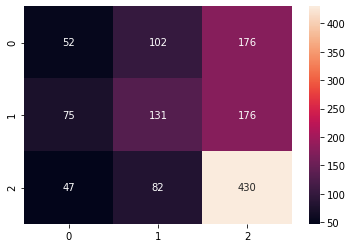

In [31]:
# predict recipient gender and print prediction results
y_pred = svm_clf.predict(X_test)
print_results(svm_clf, y_pred)

Accuracy Score ->  49.09520062942565
              precision    recall  f1-score   support

         0.0       0.29      0.09      0.14       330
         1.0       0.45      0.26      0.33       382
         2.0       0.52      0.89      0.66       559

    accuracy                           0.49      1271
   macro avg       0.42      0.41      0.37      1271
weighted avg       0.44      0.49      0.42      1271



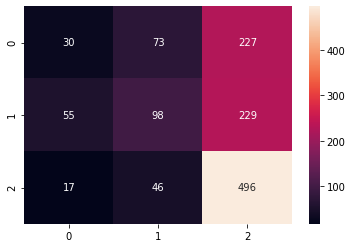

In [32]:
# predict recipient gender and print prediction results
y_pred = rf_clf.predict(X_test)
print_results(rf_clf, y_pred)

Accuracy Score ->  44.76789929189614
              precision    recall  f1-score   support

         0.0       0.33      0.23      0.27       330
         1.0       0.34      0.39      0.37       382
         2.0       0.56      0.62      0.59       559

    accuracy                           0.45      1271
   macro avg       0.41      0.41      0.41      1271
weighted avg       0.44      0.45      0.44      1271



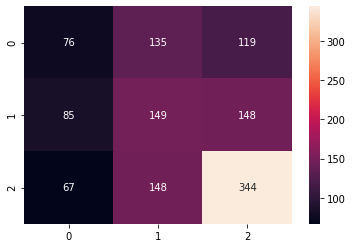

In [33]:
# predict recipient gender and print prediction results
y_pred = mlp_clf.predict(X_test)
print_results(mlp_clf, y_pred)

Accuracy Score ->  34.77576711250984


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


              precision    recall  f1-score   support

         0.0       0.29      0.29      0.29       330
         1.0       0.28      0.24      0.26       382
         2.0       0.42      0.45      0.43       559

    accuracy                           0.35      1271
   macro avg       0.33      0.33      0.33      1271
weighted avg       0.34      0.35      0.34      1271



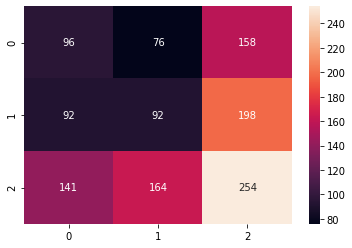

In [34]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()
clf.fit(X_train, y_train)

# predict recipient gender and print prediction results
y_pred = clf.predict(X_test)
print_results(clf, y_pred)